# Object Tracking using Python

In this notebook, we experiment with different object tracking algorithms to determine the most suitable algorithm for tracking the BB-8 droid in our video. Due to time constraints, the only algorithms we consider in our analysis are algorithms which have been implemented by contributors in OpenCV 3.4.3.

#### Load Libraries

In our implementation, we utilise the libraries listed below.

In [21]:
import sys
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print("Python Version: {}".format(sys.version.split('|')[0]))
print("OpenCV Version: {}".format(cv2.__version__))
print("Matplotlib Version: {}".format(matplotlib.__version__))

Python Version: 3.6.5 
OpenCV Version: 3.4.3
Matplotlib Version: 3.0.0


## 1. The Problem

The problem we aim to solve is to implement an object tracking algorithm which successfully tracks the BB-8 droid as it moves around in the video [1] shown below. Precisely, given a starting position, the object tracker must track the droid while it is within the field of view of the video. We are not concerned with the behaviour of the tracker when the droid is not present in the video.

<video controls width=540 src="videos/BB8.mp4" />

There are several challenges this video poses, despite being free of other potentially distracting objects. The first of these challenges in the fast erratic movement of the object we are tracking. This movement may make it harder for a tracking algorithm to estimate the direction and speed that the object is moving at and thus it's position in the next frame. Another challenge which may make tracking more difficult is that both position of the camera and the object changes throughout the video. Towards the end of the video, the droid also moves closer to the camera and consumes more of the frame. Therefore, the tracker should be resilient to changes in scale. Finally, although the scene is well lit, the colours of the droid are similar to the background objects in the scene which may make it harder for the algorithm to differentiate between the object and background.

There are many object tracking algorithms which exist, each with strengths and weaknesses. Therefore, it is essential that we understand the characteristics of the video we are using and the object(s) within the video we want to track. We must choose an appropriate object tracking algorithm which deals well with the challenges previously mentioned.

#### Load the video

In [22]:
VIDEO_PATH = "videos/Bb8 Free Roam (online-video-cutter.com).mp4"
video = cv2.VideoCapture(VIDEO_PATH)

if not video.isOpened():
    print("Could not load video.")
else:
    f_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    f_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print("Video loaded!\n")
    print("Frame width: {} px".format(f_width))
    print("Frame height: {} px".format(f_height))

Video loaded!

Frame width: 1280 px
Frame height: 720 px


## 2. Selecting a Tracking Algorithm

OpenCV 3.4.3 contains implementations of seven different object tracking algorithms [2]. Therefore, to save time and effort, it is sensible to evaluate the performance of these algorithms and assess their suitability for our task before reinventing the wheel and implementing other algorithms from scratch.

Based on some limited research we have identified the following algorithms as potentially suitable solutions. We assess the performance of these on our video.

* The Multiple Instance Learning (MIL) tracker [3]
* The Tracking, Learning and Detection (TLD) tracker [4]
*  The Boosting tracker [6]

We choose to evaluate these algorithms because they all performed consistently well for fast motion, scaling, background cluttering and rotation when assessed in a review of object tracking algorithms published by Janku et al. [5]. These are all challenges we face in our scenario.

We have not included summaries of the operating differences between these trackers here, but we have added links to the authors' papers.

In [23]:
# Uncomment the tracker to use for each run

# tracker = cv2.TrackerTLD_create()
tracker = cv2.TrackerBoosting_create()
# tracker = cv2.TrackerMIL_create()


## 3. Perform Tracking

#### Define the Initial Position of the Object

Using our quickly whipped up bounding box finder tool (bounding_box_finder.py) we can obtain the bounding box which represents the objects initial location (see below).

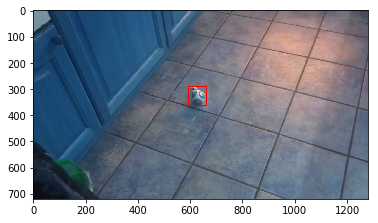

In [24]:
# Read the first video frame
ok, frame = video.read()

# Define initial bounding box
bbox = (594, 292, 69, 71) # Found using our bounding_box_finder.py tool

# Draw bounding box
p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)

plt.imshow(frame)
plt.show()

#### Perform Tracking

In [25]:
# Save annotated frames to a list
frames = [frame]

# Intialise tracker
tracker.init(frame, bbox)

while ok:
    # Read next frame
    ok, frame = video.read()
    
    # Start timer
    timer = cv2.getTickCount()
    
    # Update tracker
    target_located, bbox = tracker.update(frame)
    
    # Calculate frames per second
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    
    if target_located:
        # Draw bounding box
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
    else:
        # Draw failure text
        cv2.putText(frame, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
    
    # Display fps on frame
    cv2.putText(frame, "FPS : " + str(int(fps)), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);
    
    frames.append(frame)

#### Stitch Tracked Video

In [26]:
OUTPUT_VIDEO_PATH = "out/BB8_Boosting.mp4"
video_out = cv2.VideoWriter(OUTPUT_VIDEO_PATH,
                            cv2.VideoWriter_fourcc('h', '2', '6', '4'),
                            30,
                            (f_width, f_height))

for frame in frames:
    video_out.write(frame)
    
video_out.release()

## 4. Results

In this section, we present a qualitative evaluation of the performance of our chosen tracking algorithms. The videos shown below are included in the out/ directory and labelled according to the algorithm used. For each video, we have listed positives and negatives regarding the respective trackers performance.

#### TLD Tracking Algorithm Results

<video controls width=540 src="out/BB8_TLD.mp4" type="video/mp4" />

* Struggles with tracking the entire object (flickers between tracking the whole droid and just the position of the head).  
* Tracks the droid quite slowly (< 10 fps).  
* Struggles to accurately determine the location of the object at the end of the video when the camera angle changes and the droid is close to the camera.
* Loses the position of the droid for a couple of frames in the middle of the video.

#### Boosting Tracking Algorithm Results

<video controls width=540 src="out/BB8_Boosting.mp4" type="video/mp4" />

* Better at tracking the entire object than the TLD tracker. Still struggles to follow the droid's position smoothly.
* Compare to TLD the algorithm does not lose track of the object at any point in the video.
* Tracks the object at a higher framerate (~30fps) compared to TLD.

#### MIL Tracking Algorithm Results

<video controls width=540 src="out/BB8_MIL.mp4" type="video/mp4" />

* Smoother, less jittery tracking compared to the Boosting algorithm.
* Lower framerate (~20 fps) compared to the Boosting algorithm.

## 5. Conclusion

From our qualitative assessment of the performance of the tested object trackers, we conclude that **the MIL tracking algorithm presents the best option for our task**.

Compared to the TLD tracker, the MIL algorithm consistently tracks the entire object (not just parts of the object) and maintains the size of the bounding box. The MIL tracker also does not lose the object at all during the clip. At the very end of the clip, the object is closer to the camera and therefore appears larger. In this part of the video, the TLD struggles to accurately determine the location of the object whereas the MIL algorithm suffers from no such problem.

Compared to the Boosting tracker, the MIL tracker manages to follow the droid more smoothly, albeit at a lower framerate. If the application requires closer to real-time tracking, the Boosting tracker may prove a better alternative.

Due to time constraints, we were only able to assess the performance of a few tracking algorithms and provide a rudimentary analysis of their comparative performance. For further investigation, we would more thoroughly research the literature of different tracking algorithms and dig deeper into the reasons for some of the shortcomings of the algorithms tested.

## References and Acknowledgements

[1] https://www.youtube.com/watch?v=hPPJjKCBVPk  
[2] https://docs.opencv.org/3.4.3/d2/d0a/tutorial_introduction_to_tracker.html  
[3] http://faculty.ucmerced.edu/mhyang/papers/cvpr09a.pdf  
[4] http://epubs.surrey.ac.uk/713800/1/Kalal-PAMI-2011(1).pdf  
[5] https://www.matec-conferences.org/articles/matecconf/pdf/2016/39/matecconf_cscc2016_04031.pdf  
[6] https://pdfs.semanticscholar.org/3a68/0eb285f31d6a72848530dec640d83c02a364.pdf

OpenCV Python tracker code largely modified from https://www.learnopencv.com/object-tracking-using-opencv-cpp-python/.